In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
import json

## Standard VAE + Bedford VAE

In [35]:
abspath = "./VAE_standard"

In [36]:
sys.path.append(abspath)
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import bedford_code.models_bedford as bedford
from treetime.utils import datetime_from_numeric
import pymc as pm
from collections.abc import Iterable
import altair as alt

In [37]:
BATCH_SIZE = 64
# "data" directory is generated as shown in README.md file
dataset = DNADataset(f"{abspath}/../data/training_spike.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [38]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [39]:
input_dim = len(ALPHABET) * SEQ_LENGTH
# input_dim = 29903 * 5
# input_dim = 29903

# BEDFORD
# vae_model = bedford.VAE(input_dim=len(bedford.ALPHABET) * bedford.SEQ_LENGTH, latent_dim=bedford.LATENT_DIM).to(DEVICE)
# vae_model.load_state_dict(torch.load(f"{abspath}/bedford_code/results_bedford/BEST_vae_ce_anneal.pth"))
#STANDARD
vae_model = VAE(input_dim=input_dim, latent_dim=50).to(DEVICE)
vae_model.load_state_dict(torch.load(f"{abspath}/model_saves/standard_VAE_model_BEST.pth", weights_only=True, map_location=DEVICE))


vae_model.eval()

VAE(
  (non_linear_activation): ReLU()
  (encoder): Encoder(
    (non_linear_activation): ReLU()
    (encode): Sequential(
      (0): Linear(in_features=19110, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
    )
    (fc_mean): Linear(in_features=256, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (non_linear_activation): ReLU()
    (means): ModuleList(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=19110, bias=True)
    )
  )
)

In [186]:
dset = ["training", "valid", "test"]
dset = dset[0]
print(dset)
abspath = "."
dataset = DNADataset(f"{abspath}/data/{dset}_spike.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
vals = np.array([dataset[x][1] for x in range(len(dataset))])
# labeling
metadata = pd.read_csv(f"{abspath}/data/all_data/all_metadata.tsv", sep="\t")
clade_labels = [metadata.loc[metadata.name == vals[i], "clade_membership"].values[0] for i in range(len(vals))]
dates = [metadata.loc[metadata.name == vals[i], "date"].values[0] for i in range(len(vals))]
dates = [datetime_from_numeric(x) for x in dates]

training


In [173]:
def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, float)):
            yield from flatten(x)
        else:
            yield x

collection_dates = pd.DataFrame([[x] for i,x in enumerate(dates)], columns=["date"])
collection_dates.index = pd.to_datetime(collection_dates["date"])
collection_dates = collection_dates.groupby(pd.Grouper(freq='W'))
collection_dates = list(collection_dates.groups.values())
print(collection_dates)
collection_dates = [collection_dates[0]] + [collection_dates[i] - collection_dates[i-1] for i in range(len(collection_dates)-1, 0, -1)][::-1]
collection_dates = list(flatten([[i for j in range(x)] for i,x in enumerate(collection_dates)]))

[3, 14, 15, 18, 30, 35, 38, 46, 54, 57, 62, 63, 65, 70, 73, 78, 83, 90, 93, 97, 102, 106, 115, 121, 122, 133, 142, 146, 148, 151, 154, 167, 175, 181, 187, 193, 198, 200, 201, 210, 212, 216, 218, 222, 225, 230, 235, 240, 243, 247, 248, 253, 258, 260, 260, 264, 267, 268, 270, 270, 275, 278, 278, 281, 281, 284, 285, 287, 287, 289, 290, 290, 290, 290, 291, 294, 299, 305, 310, 314, 319, 325, 333, 336, 336, 339, 343, 345, 346, 351, 357, 358, 361, 363, 366, 369, 372, 375, 376, 376, 382, 383, 385, 386, 386, 389, 396, 397, 397, 399, 403, 404, 408, 409, 412, 414, 415, 417, 419, 419, 425, 426, 431, 432, 432, 435, 435, 436, 439, 442, 467, 475, 489, 602, 743, 831, 961, 1103, 1234, 1397, 1524, 2030, 2517, 2860, 3239, 3528, 3758, 4033, 4252, 4555, 4816, 5018, 5361, 5558, 5817, 6057, 6274, 6368]


In [174]:
good_clade_labels = []
for c in clade_labels:
    if len(metadata[metadata.clade_membership == c]) > 5:
        good_clade_labels.append(c)
print(set(good_clade_labels))

{'25B (NB.1.8.1)', '24D (XDV.1)', '23A (XBB.1.5)', '19A', '22B (BA.5)', '25A (LP.8.1)', '21K (BA.1)', '22A (BA.4)', '23F (EG.5.1)', '23I (BA.2.86)', '22D (BA.2.75)', '23D (XBB.1.9)', '24H (LF.7)', '22F (XBB)', '24A (JN.1)', '25C (XFG)', '24I (MV.1)', '21L (BA.2)', '23B (XBB.1.16)', '22C (BA.2.12.1)', '24E (KP.3.1.1)', '24F (XEC)'}


In [175]:
# print(set(clade_labels))

# clusters = np.sort(np.array(list(set(good_clade_labels))))
clusters = np.sort(np.array(list(set(clade_labels))))
print(clusters)
get_clade = lambda x: [True if elem == x else False for elem in clade_labels]

indexes = tuple([np.arange(len(clade_labels))[get_clade(x)] for x in clusters])

['19A' '21K (BA.1)' '21L (BA.2)' '21M (Omicron)' '22A (BA.4)' '22B (BA.5)'
 '22C (BA.2.12.1)' '22D (BA.2.75)' '22E (BQ.1)' '22F (XBB)'
 '23A (XBB.1.5)' '23B (XBB.1.16)' '23C (CH.1.1)' '23D (XBB.1.9)'
 '23E (XBB.2.3)' '23F (EG.5.1)' '23G (XBB.1.5.70)' '23H (HK.3)'
 '23I (BA.2.86)' '24A (JN.1)' '24D (XDV.1)' '24E (KP.3.1.1)' '24F (XEC)'
 '24G (KP.2.3)' '24H (LF.7)' '24I (MV.1)' '25A (LP.8.1)' '25B (NB.1.8.1)'
 '25C (XFG)']


In [176]:
new_vals = []
for v in vals:
    if metadata.loc[metadata.name == v, "clade_membership"].values[0] in clusters:
        new_vals.append(v)

In [177]:
parents = pd.read_csv(f"{abspath}/data/all_data/all_branches.tsv", sep="\t")
node_dict = {x:i for i,x in enumerate(new_vals)}
pairs = []
for p,c in zip(parents["parent"], parents["child"]):
    i1 = node_dict.get(p, None)
    i2 = node_dict.get(c, None)

    if i1 and i2:
        pairs.append((i1,i2))

pairs = np.array(pairs)

X shape
(6368, 3822, 5)
torch.Size([6368, 3822, 5])

Recon shape
torch.Size([6368, 19110])
[0.45191533 0.33159555 0.19805563]
total variance: 0.9815665069351586


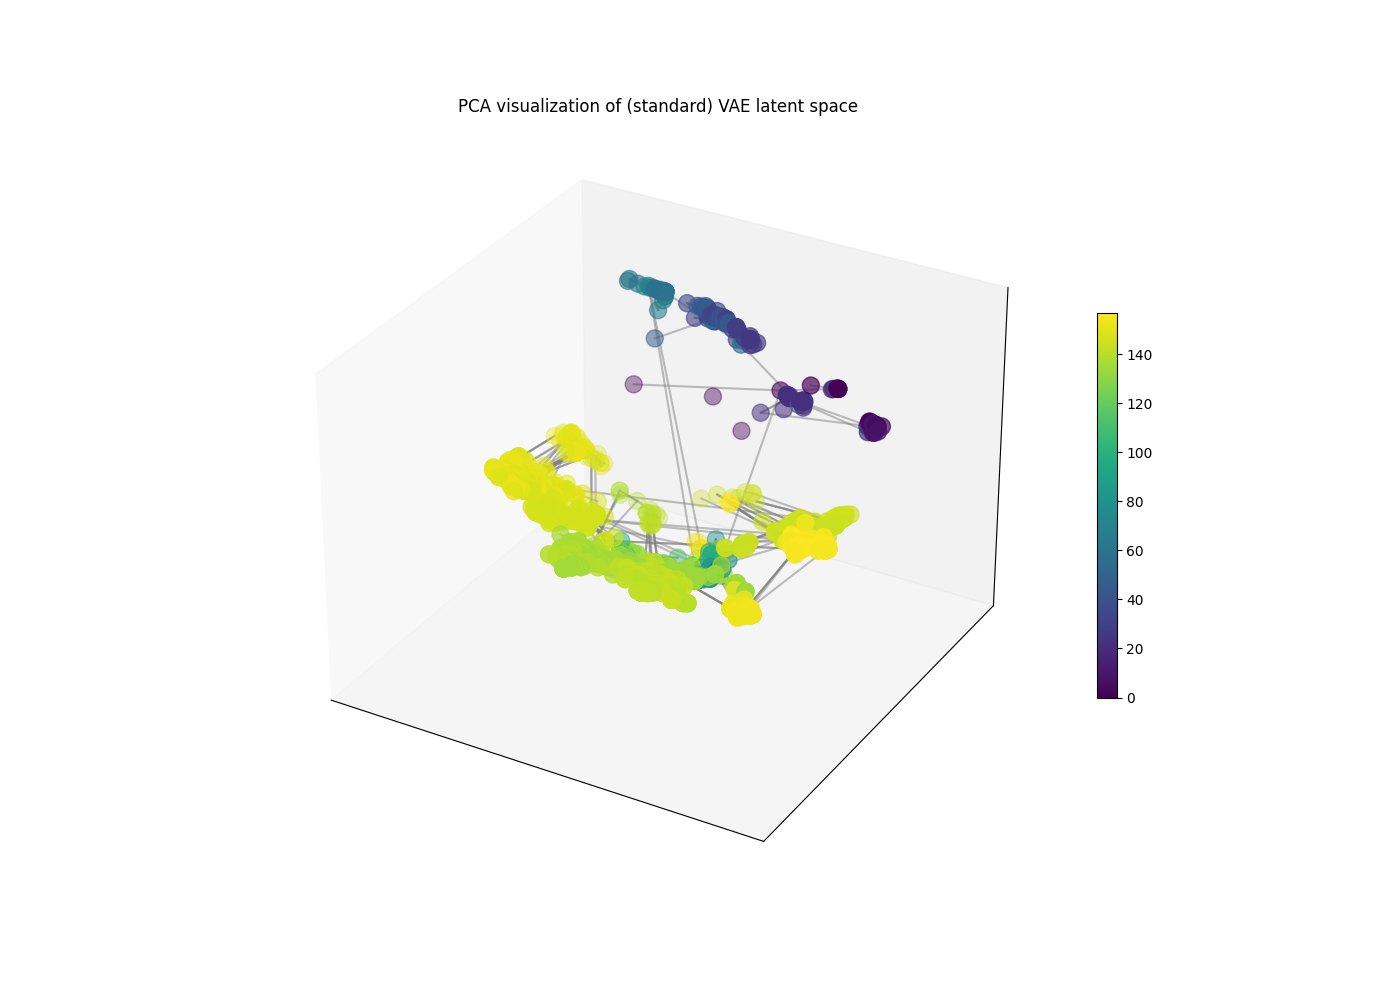

In [209]:
cmap = plt.get_cmap("gist_ncar")
colors = [cmap(x) for x in np.arange(len(indexes)) / len(indexes)]

ranges = np.concatenate(indexes)

X = torch.tensor(new_dataset[ranges,:,:])
print("X shape")
print(new_dataset.shape)
print(X.shape)
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)
pca = PCA(n_components=3, svd_solver="full")


recon = None
Z_mean = None
Z_embedded = None
scatterplot = None
with torch.no_grad():
    # STANDARD
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    recon = vae_model.decoder.forward(Z_mean)
    recon = recon.view(recon.shape[0], -1).cpu()
    Z_mean = Z_mean.cpu()
    Z_std = torch.exp(0.5 * Z_logvar).cpu()

    # BEDFORD
    # recon, Z_mean, Z_logvar = vae_model.forward(X)
    # recon = recon.cpu().numpy()
    # Z_mean = Z_mean.cpu().numpy()
    
    print("\nRecon shape")
    print(recon.shape)
    
    # Z_embedded = tsne(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X = Z_mean)
    pca.fit(Z_mean)
    Z_embedded = pca.transform(Z_mean - torch.mean(Z_mean))
    variances = pca.explained_variance_ratio_
    tot = np.sum(variances)
    print(variances)
    print(f"total variance: {tot}")
    curr = 0
    

%matplotlib widget
fig,ax = plt.subplots(1,1,figsize=(14,10),subplot_kw=dict(projection="3d"))

# RELATIONS
# for i,arr in enumerate(indexes):
#     ax.scatter(Z_embedded[arr,0], Z_embedded[arr,1], Z_embedded[arr, 2], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=150)
#     curr += len(arr)
# l1 = 0.1
# l2 = 0
# ax.legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))

# TIME 
scatterplot = ax.scatter(Z_embedded[:,0], Z_embedded[:,1], Z_embedded[:,2], c=collection_dates, cmap="viridis", s=150)
fig.colorbar(scatterplot, ax=ax, shrink=0.5)

ax.set_title("PCA visualization of (standard) VAE latent space")
for p in pairs:
    ax.plot(Z_embedded[p,0], Z_embedded[p,1], Z_embedded[p,2], color="gray", alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.ion()
plt.show()

# plotting_dict = pd.DataFrame([(x1,x2,x3,c) for (x1,x2,x3),c in zip(Z_embedded, collection_dates)], columns=["dim0","dim1","dim2","date"])
# alt.data_transformers.disable_max_rows()
# alt.Chart(plotting_dict).mark_circle(size=60).encode(
#     x='dim0',
#     y='dim1',
#     # z='dim3',
#     color='date',
#     tooltip=['dim0', 'dim1', 'date']
# ).properties(
#     width=1000,
#     height=550
# ).interactive()


In [107]:
print(pca.components_.shape)
print(pca.singular_values_)

(3, 50)
[136.81514595 117.19524374  90.57309999]


In [ ]:
genome = X.view(X.shape[0], -1, len(ALPHABET)).cpu().numpy().astype("int")
genome = np.matmul(genome, np.arange(len(ALPHABET)))

In [ ]:
from collections.abc import Iterable
def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, float)):
            yield from flatten(x)
        else:
            yield x

In [ ]:
N = Z_embedded.shape[0]
print(N)
hamming = list(flatten([np.sum(np.not_equal(genome[i,:],genome[(i+1):,:]),axis=-1) for i in range(N-1)]))
euclid = list(flatten([np.linalg.norm((Z_embedded[(i+1):,:] - Z_embedded[i,:]), axis=-1) for i in range(N-1)]))

fig,arr = plt.subplots(1,1,figsize=(14,10))
arr.set_title("Hamming vs. Euclidean dist")
arr.scatter(hamming, euclid, alpha=0.3)
plt.show()

## GP regression

In [187]:
print(metadata.columns)

Index(['name', 'parent', 'date', 'clade_membership', 'S1_mutations'], dtype='object')


In [188]:
X = torch.tensor(new_dataset[ranges,:,:])
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)
print("X shape")
print(new_dataset.shape)
print(X.shape)

pca = PCA(n_components=3, svd_solver="full")

Z_mean = None
Z_embedded = None
with torch.no_grad():
    # STANDARD
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    recon = vae_model.decoder.forward(Z_mean)
    recon = recon.view(recon.shape[0], -1).cpu()
    Z_mean = Z_mean.cpu()
    Z_std = torch.exp(0.5 * Z_logvar).cpu()
    # BEDFORD
    # recon, Z_mean, Z_logvar = vae_model.forward(X)
    # recon = recon.cpu().numpy()
    # Z_mean = Z_mean.cpu().numpy()

    pca.fit(Z_mean)
    Z_embedded = pca.transform(Z_mean - torch.mean(Z_mean))
    variances = pca.explained_variance_ratio_
    tot = np.sum(variances)
    print("\n",variances)
    print(f"total variance: {tot}")

X shape
(6368, 3822, 5)
torch.Size([6368, 19110])

 [0.45191533 0.33159555 0.19805563]
total variance: 0.9815665069351586


In [205]:
metadata = pd.read_csv(f"{abspath}/data/all_data/all_metadata.tsv", sep="\t")
clade_labels = [metadata.loc[metadata.name == vals[i], "clade_membership"].values[0] for i in range(len(vals))]
dates = [metadata.loc[metadata.name == vals[i], "date"].values[0] for i in range(len(vals))]
dates = [datetime_from_numeric(x) for x in dates]

coords = [(x1,x2,x3,t,c) for (x1,x2,x3),t,c in zip(Z_embedded, dates,clade_labels)]
coords = pd.DataFrame(data=coords, columns=["dim0","dim1","dim2","time","clade"])

In [213]:
avg_coords = coords.groupby("time")[["dim0","dim1","dim2"]].median().resample("ME").median().dropna().reset_index()

In [222]:
x_vals = np.array(range(len(avg_coords)))[:,np.newaxis].astype("float32")
# import theano.tensor as tt
def build_coords_model(dim):
    y_vals = avg_coords[dim].values.astype('float32')
    print(x_vals.shape, y_vals.shape)

    with pm.Model() as model:
        # l = pm.HalfCauchy('l', beta=20)
        l = pm.Uniform('l', 0, 30)

        # Covariance function
        log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
        s2_f = pm.Deterministic('s2_f', np.exp(log_s2_f))
        # s2_f = pm.HalfCauchy('s2_f', beta=2)
        # f_cov = s2_f * pm.gp.cov.Matern52(input_dim=1, lengthscales=l)
        f_cov = s2_f * pm.gp.cov.ExpQuad(input_dim=1, ls=l)

        # Sigma
        log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
        s2_n = pm.Deterministic('s2_n', np.exp(log_s2_n))
        # s2_n = pm.HalfCauchy('s2_n', beta=2)
        
        y_obs = pm.gp.conditional('y_obs', cov_func=f_cov, sigma=s2_n, 
                         observed={'X':x_vals, 
                                   'Y':y_vals})
        trace = pm.sample(2000)

        pp_x = np.arange(len(avg_coords_by_quarter)+2)[:, None]
        gp_samples = pm.gp.sample_gp(trace=trace, gp=y_obs, X_values=pp_x, samples=1000)

    return gp_samples

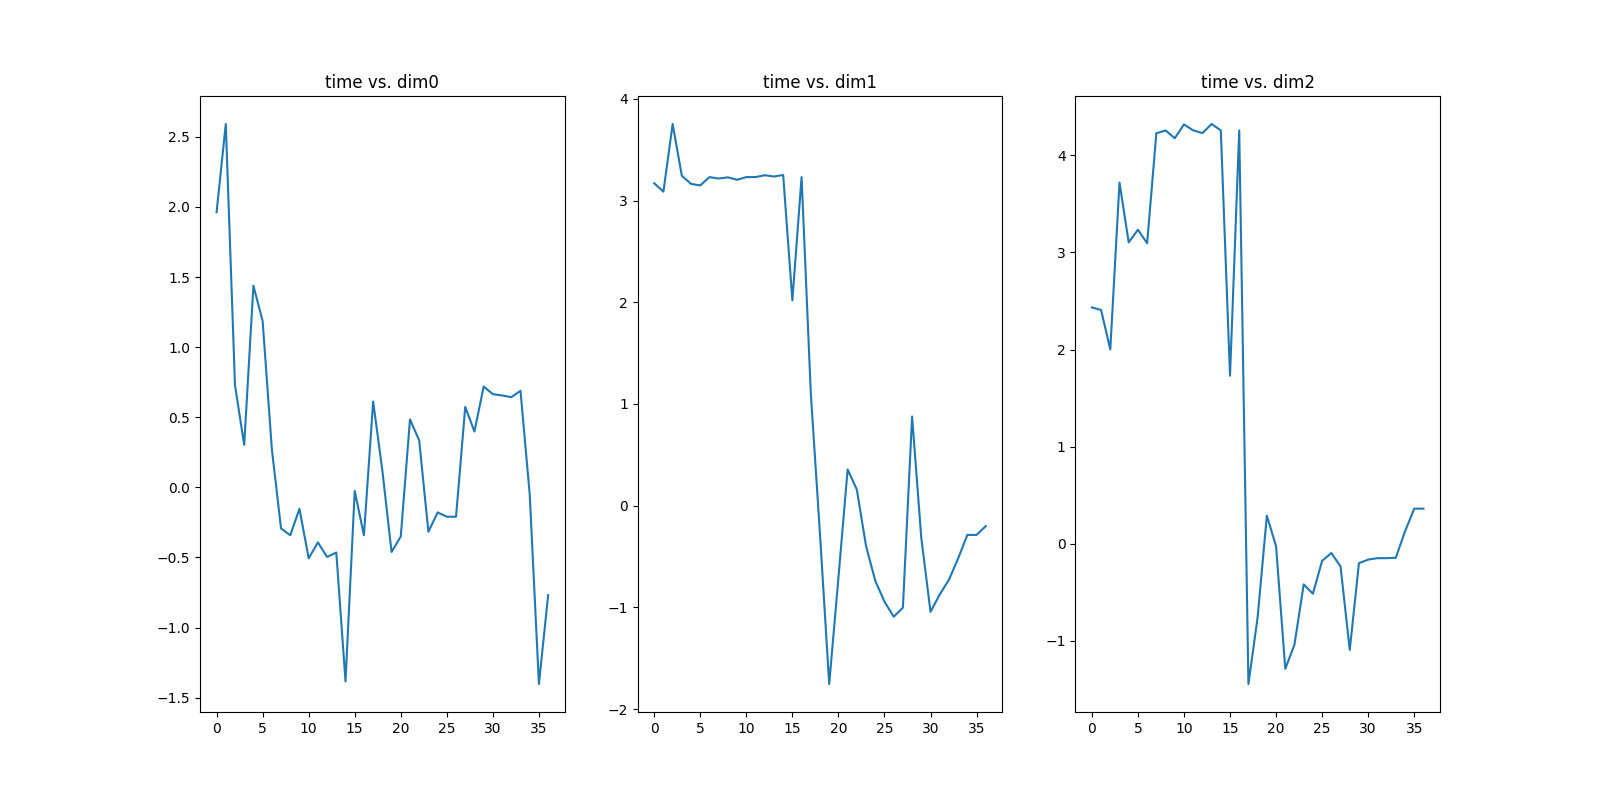

In [223]:
fig,ax = plt.subplots(1,3,figsize=(16,8))
for i,d in enumerate(["dim0","dim1","dim2"]):
    ax[i].plot(list(range(len(avg_coords))), avg_coords[d])
    ax[i].set_title(f"time vs. {d}")
plt.show()